In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import convolution
from ipywidgets import interact, IntSlider
import scipy
import scipy.misc
from skimage import data
import numpy as np

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

# 畳み込み



## 畳み込みの働き

* フィルタの濃淡パターンと類似した濃淡パターンが入力画像上どこにあるかを検出してくれる働きがある
* 要は特徴的な構造を抽出してくれるって話

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


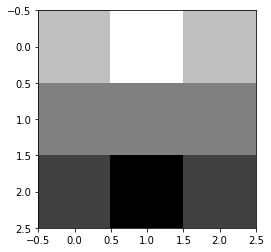

In [24]:
# こんなフィルタを用意してみる
horizontal_edge_kernel = np.array([[1,  2,  1],
                                   [ 0,  0,  0],
                                   [-1, -2, -1]])
plt.imshow(horizontal_edge_kernel);

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


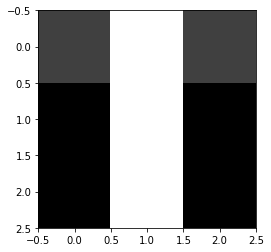

In [25]:
# こんなフィルタも用意してみる
horizontal_edge_kernel2 = np.array([[0,  3,  0],
                                   [ -1, 3,  -1],
                                   [-1, 3, -1]])
plt.imshow(horizontal_edge_kernel2);

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


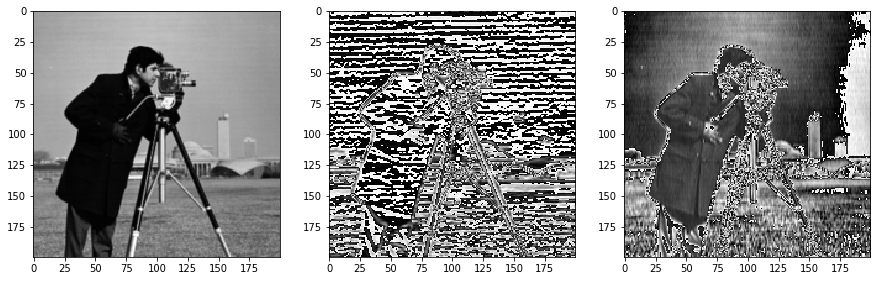

In [29]:
# カメラのおっさんの画像を畳み込んでみる
from scipy.ndimage import convolve

image = scipy.misc.imresize(data.camera(), (200, 200))
horizontal_edge_response = convolve(image, horizontal_edge_kernel)
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(horizontal_edge_response);
horizontal_edge_response = convolve(image, horizontal_edge_kernel2)
plt.subplot(1, 3, 3)
plt.imshow(horizontal_edge_response);

とまぁ、こういう感じで、フィルタの値や大きさを変えることで、特徴量の取れ方が変わってきます。

## なんでこういうのが必要なの？

* これまで学んできた全結合層だけでは画像を学習するのは難しい
* データの形状が”無視”されてしまう問題
* 画像は3次元の形状が存在するので、全結合層のようにInputが2次元とかにしちゃうと３次元の情報が失われる（可能性がある？）
* 畳み込みは形状を保持して次の層へ渡すことができるので正しく理解できる可能性がある


In [5]:
image_resize = scipy.misc.imresize(data.camera(), (32, 32))
mean_kernel = np.ones((3, 3), dtype=float) # kernelとかfilterとか呼ばれるやつ
mean_kernel /= mean_kernel.size

In [6]:
mean_kernel

array([[ 0.11111111,  0.11111111,  0.11111111],
       [ 0.11111111,  0.11111111,  0.11111111],
       [ 0.11111111,  0.11111111,  0.11111111]])

In [9]:
def plot(image_pair, **kwargs):
    convolution.imshow_pair(image_pair, **kwargs)
    plt.show()
    

def interactive_convolution_demo(image, kernel, **kwargs):
    stepper = convolution.make_convolution_step_function(image, kernel)
    plotter = lambda i_step, **kwargs: plot(stepper(i_step), **kwargs)
    step_slider = IntSlider(min=0, max=image.size-1, value=0)
    interact(plotter, i_step=step_slider)

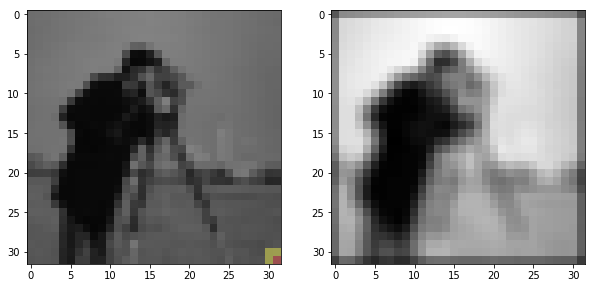

In [10]:
# ipywidgetsを使って可視化する
titles = ('filter動作', '畳み込まれた')
interactive_convolution_demo(image_resize, mean_kernel, vmax=180, titles=titles)

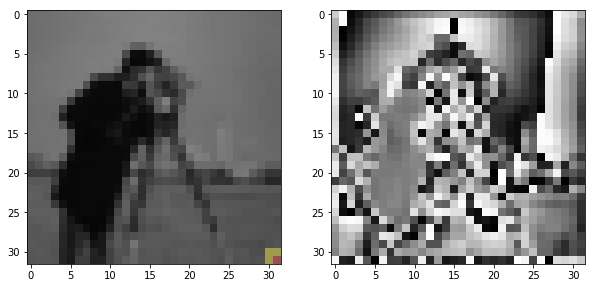

In [11]:
image_resize = scipy.misc.imresize(data.camera(), (32, 32))
mean_kernel = np.ones((3, 3), dtype=float) # kernelとかfilterとか呼ばれるやつ
mean_kernel /= mean_kernel.size
mean_kernel[:, 1] = 3 # 真ん中の濃淡を強くする

# ipywidgetsを使って可視化する
titles = ('filter動作', '畳み込まれた')
interactive_convolution_demo(image_resize, mean_kernel, vmax=180, titles=titles)

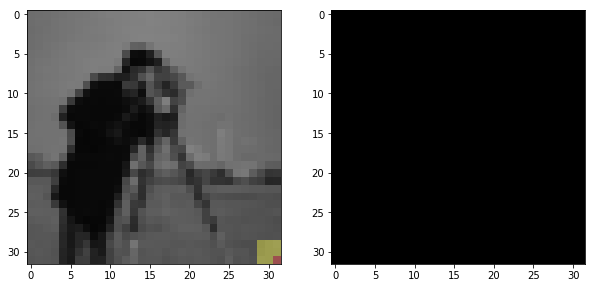

In [12]:
image_resize = scipy.misc.imresize(data.camera(), (32, 32))
mean_kernel = np.zeros([5, 5]).astype(np.float) # 全部0

# ipywidgetsを使って可視化する
titles = ('filter動作', '畳み込まれた')
interactive_convolution_demo(image_resize, mean_kernel, vmax=180, titles=titles)

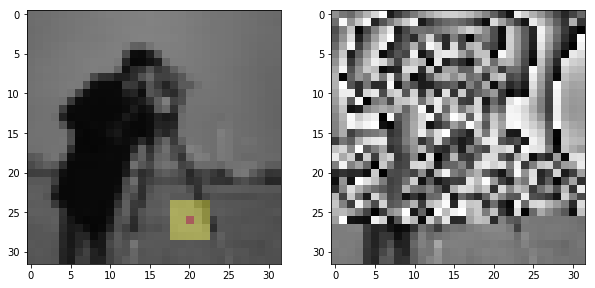

In [13]:
image_resize = scipy.misc.imresize(data.camera(), (32, 32))
mean_kernel = np.ones([5, 5]).astype(np.float) # 全部1

# ipywidgetsを使って可視化する
titles = ('filter動作', '畳み込まれた')
interactive_convolution_demo(image_resize, mean_kernel, vmax=180, titles=titles)

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


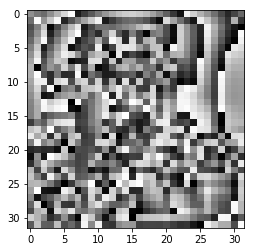

In [14]:
convolution_func = convolution.make_convolution_step_function(image_resize, mean_kernel)
for i_step in range(image_resize.size):
    output = convolution_func(i_step=i_step)[1]
plt.imshow(output)

## パディング（padding）

* 畳み込みを行うと、画像が小さくなる
* Wを画像のサイズ、Hをfilterのサイズとおいた時
* $(W - 2\lfloor H / 2 \rfloor) * (W - 2\lfloor H / 2 \rfloor)$ と表せる
* 例えば、8x8の画像を3x3のfilterで畳み込んだ場合 $(8 - 2 \lfloor 3 / 2 \rfloor) * (8 -2 \lfloor 3 / 2 \rfloor) = (8 - 2 * 1) * (8 - 2 * 1) = 6 * 6$ となる
* 畳み込みに入力した画像サイズとアウトプットの画像が同じサイズだとうれしいことがあるらしい
   * 多分だけど、畳み込みを長い層を構築したときに調節できるから便利ってことだと 思う
* 5x5の画像を(1, 1)でパディングしたら、画像を囲むように値が0でパディングされる（ゼロパディング）

<img src="./img/zero_padding.jpg">

## ストライド（stride）

* 畳み込みするとき、フィルタを1画素ずつ動かすってこれまで書いてあったけど、実はそのサイズは変えることができる！！！
* このフィルタの適用位置のｶﾝｶｸをストライドと呼ぶ
* 大きい画像を処理する場合、畳込みの出力ユニット数が大きくなってしまうので、それを防ぐことができる
* しかし、場合によっては特徴量を取りこぼす可能性あり。お取扱い注意

$$
\begin{align}
u_{ij}= \sum_{p=0}^{H-1} \sum_{q=0}^{H-1} x_{si+p, sj+q} h_{pq}
\end{align}
$$

<img src="./img/stride1.gif">

<img src="./img/stride2.gif">

# 畳み込み層

* 畳み込み、パディング、ストライドを組み合わせてやってくれる層のことです
* 演算の内容はほとんどかわりません
* ただ、実用的になってくると多チャネル（色の深さ ≒ チャネル数）の画像を学習させるので、前節ででた計算を変更する必要あり
* 多チャネルについて、上に書いた通り。例えばRGBの画像は３つの画素をもつので$K=3$とする。グレースケールだと$K=1$となる（0 ~ 255で表現できるので）
* 画像の縦横の画素数が$W \times W$で、チャネル数が$K$の時、この画像のサイズを$W \times W \times K$と表すことにする
    * 文献によっては中間層ででてくる画像のことをmap（マップ）って呼んだりするんだって
* はい、数式書くよー
* ある畳み込み層が第$l$層に位置してたとして、直前の第$l - 1$層からKチャネルの画像$z_{ijk}^{(l-1)}(k = 0, \dots, K - 1)$を受け取る
* これに$M(=3)$種類のフィルタ$h_{pqkm}(m = 0, \dots, M - 1)$を適用する
* んで、各フィルタは入力とonaziチャネル数Kを持ち、そのサイズを$H \times H \times K$とする
* 各フィルタ$m(=0, 1, 2)$について、平行に計算が実行されてそれぞれ1チャネルの$u_{ijm}$が出力される

<img src="./img/IMG_0794.png">

$$
\begin{align}
u_{ijm}= \sum_{k=0}^{K-1} \sum_{p=0}^{H-1} \sum_{q=0}^{H-1} z_{i+p, j+q, k}^{(l-1)} h_{pqkm} + b_{ijm}
\end{align}
$$

* 上の式のように表せます
* バイアスはフィルタ毎に各ユニット共通$(b_{ijm} = b_{m})$ とするのが一般的
   * 単純に行列の足し算になるイメージ？ 足したら色が濃くなりそう
* この式で得た$u_{ijm}$を活性化関数に食わせる
   * $z_{ijm} = f(u_{ijm})$ 
* ストライドを2以上にすると出力画像は小さくなります

* まとめ
    * 畳み込み層の入力と出力のユニット数は$W \times W \times K$と$W \times W \times M$
    * 畳み込み計算の居所性を反映して、出力層のユニット１つ（チャネルmの１つの画素）は、入力層$H \times H \times K$個のユニットとのみ結合
    * その結合の重みがフィルタの係数$h_{pqkm}$（もしm=0だったら、上の画像のm=0のフィルタの重みとなる）
    * この重みは出力層の同一のチャネルの全ユニットで同じである（！？）
    * このことを重み共有（weight sharing, weight tying）と呼ばれる
        * よくわからんけど、例えば、m=0で特徴量見つけたよ！ってなったとする
        * しかし、その見つけたい特徴量がm=０以外のフィルタに入ってしまったとき、特徴量を取りこぼしてしまう可能性がある
        * じゃあ共有しましょ。という認識をもっています。まだ理論はわからんけど

# プーリング層

* 畳み込み層の直後に設置される
* 畳み込み層で抽出された特徴の位置感度を若干低下させることで対象とする特徴量の画像内での位置が若干変化した場合でも、プーリング層の出力が不変になるようにします
* なるほどなー（言い回し難しい）

<img src="./img/maxpool.jpeg">

* やっていることは画像に被せるフィルター上で一番大きい値を選択して出力している（これは最大プーリング max poolingと呼ばれる）
* 他にも平均プーリング（average pooling）やLpプーリング（Lp pooling）といったものがある

max pooling
$$
\begin{align}
u_{ijk}= \max_{(p, q)\in{P_{ij}}} z_{pqk}
\end{align}
$$

average pooling
$$
\begin{align}
u_{ijk}= \frac{1}{H^2} \sum_{(p,q)\in{P_{i,j}}} z_{pqk}
\end{align}
$$

Lp pooling
$$
\begin{align}
u_{ijk}= \bigl(\frac{1}{H^2} \sum_{(p,q)\in{P_{i,j}}} z_{pqk}^P\bigr)^\frac{1}{P}
\end{align}
$$

* プーリング層でもストライドを設定することができます（てかそれが普通とのこと）
* プーリング層では活性化関数を適応するのは可能だけど、普通はしません。学習によって変化するパラメータもないとのこと
* 「本設で述べたように、プーリング層の処理自体は単純なものですが、多層の畳み込みネットの中で果たす役割や、最大プーリングや平均プーリングなどの種類と効果の違いなど、**不明なことも残されています**」
* マジカヨ（°ω°

# 正規化層

* 自然な画像は明るさだったり、コントラストの違いなどがあるので、それらをうまく吸収する必要がある
* 我々人はそれらを調節する機能があるので、大丈夫（急に真っ暗になったら何も見えなくなるけどだんだん目が慣れてきてちょっとは見えるようになる感じ？）
* けど、機械にはないのでどーにかする必要がある

## 学習画素ごとの平均

正規化の手法として、統計量を揃える方法がある。学習画像の画素ごとの平均を求めて、ターゲットの画像から引けばおｋ

$$
\begin{align}
\tilde{x}_{ijk}= \sum_{n=1}^{N} x_{ijk}^{(n)} \\
x_{ijk} = x_{ijk} - \tilde{x}_{ijk}
\end{align}
$$

In [14]:
import cv2

# 適当に水増し
def increase():
    images = []
    image = data.lena()
    images.append(image)
    
    # 平滑化
    average_square = (10,10)
    blur_img = cv2.blur(image, average_square)
    images.append(blur_img)

    # 反転
    hflip_img = cv2.flip(image, 1)
    vflip_img = cv2.flip(image, 0)
    images.append(hflip_img)
    images.append(vflip_img)
    
    return images

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


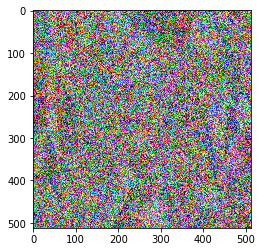

In [15]:
# こんな感じ？
n = 0
images = increase()
images_mean = np.mean(images, axis=0)
x_ijk = images[0] - images_mean
plt.imshow(x_ijk)

!!?

量が多いならなんとかなるのだろうか・・・？

## 局所コントラスト正規化（local constrast normalization)

* さっきは全部の画像を使いましたが、今回は画像１枚１枚に対して個別に行う処理です
* 一般的な画像処理の手法。誤差逆伝播計算も可能
* 重みは固定値なので、学習の対象となるパラメータはなし
* 減算正規化（subtractive normalization）と除算正規化（divisive normalization)の２つがある

<img src="./img/weight.png">

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


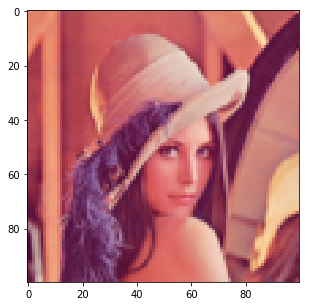

In [18]:
import math, sys
import scipy.stats as st

def norm_filter(size, sigma=1):
    r= math.floor(size/2)
    if (size %2) != 0:
        pad = 0
    else:
        pad = 1
    x = np.linspace(-r + pad, r, size)
    y = np.linspace(-r + pad, r, size)
    X, Y = np.meshgrid(x, y)
    
    Z = st.multivariate_normal.pdf(np.dstack((X,Y)), mean=[0,0], cov=[[sigma,0],[0,sigma]])
    plus = (1. - np.sum(Z)) / float(size * size)
    return Z + plus


def add_padding_center(data, filter_size):
    if type(data) != np.ndarray:
        raise Exception('data must be numpy.ndarray')  
        
    image_shape = data.shape
    if (filter_size %2) != 0:
        # odd
        pad_size = (filter_size -1) // 2
    else:
        #even
        pad_size = filter_size // 2
    return np.pad(data, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant',  constant_values=0), pad_size


# prepare filter
plt.figure(figsize=(5,5))
im_lenna = scipy.misc.imresize(data.lena(), (100, 100))
plt.imshow(im_lenna)

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


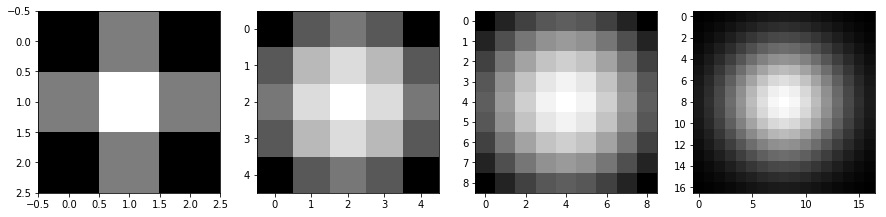

In [19]:
plt.figure(figsize=(15,15))
filter_sizes = [3, 5, 9, 17]
# filter_size -> H
for index, filter_size in enumerate(filter_sizes):
    norm_f = norm_filter(filter_size, sigma=15)
    plt.subplot(1, len(filter_sizes), index + 1)
    plt.imshow(norm_f.flatten().reshape(filter_size, filter_size)[::-1,:], cmap='gray')

"領域の中央で最大値をとり 、周辺部へ向けて低下するようなもの"はこのこと。白が大きく、黒が小さい

これはもしかしなくてもガウシアンフィルタじゃね？

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


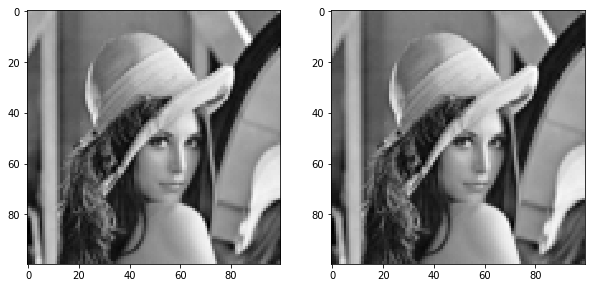

In [20]:
plt.figure(figsize=(10, 5))
gray_im_lenna = cv2.cvtColor(scipy.misc.imresize(data.lena(), (100, 100)), cv2.COLOR_RGB2GRAY)
plt.subplot(1, 2, 1)
plt.imshow(gray_im_lenna, cmap='gray')
gray_im_lenna = gray_im_lenna.astype(np.float32)
# Rescaling
gray_im_lenna = (gray_im_lenna - np.min(gray_im_lenna)) / float(np.max(gray_im_lenna) - np.min(gray_im_lenna))
plt.subplot(1, 2, 2)
plt.imshow(gray_im_lenna, cmap='gray')

殆ど変わりはないけど、数値は小さくなった

In [21]:
def subtractive(im_lenna, filter_size, norm_f):
    gray_im_lenna = cv2.cvtColor(im_lenna, cv2.COLOR_RGB2GRAY)
    image_size = gray_im_lenna.shape[0]
    gray_im_lenna = gray_im_lenna.astype(np.float32)
    # Rescaling. これないと処理がすごく遅い
    gray_im_lenna = (gray_im_lenna - np.min(gray_im_lenna)) / float(np.max(gray_im_lenna) - np.min(gray_im_lenna))
    padded_lenna, pad_size = add_padding_center(gray_im_lenna, filter_size)

    nditer = np.nditer(np.mgrid[0:image_size, 0:image_size][0], flags=['multi_index'])
    while not nditer.finished:
            # ※1
            # norm_f[p, q] -> 重み
            # padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] -> x_{i + p, j + q}
            # 上の計算が終わったら引けば減算正規化
            padded_lenna[nditer.multi_index] -= np.sum([padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] * norm_f[p, q] \
                                                                                           for p in range(filter_size) for q in range(filter_size)])
            nditer.iternext()

    plt.imshow(padded_lenna, cmap='gray')

※1計算式

$$
\begin{align}
\bar{x}_{ijk}= \sum_{(p,q)\in{P_{ij}}} w_{pq}x_{i + p, j + q}
\end{align}
$$

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


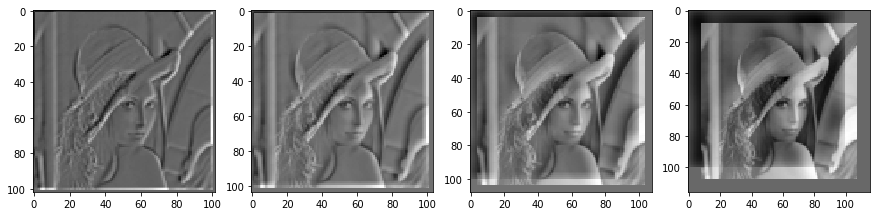

In [24]:
filter_sizes = [3, 5, 9, 17]
plt.figure(figsize=(15, 15))
im_lenna = scipy.misc.imresize(data.lena(), (100, 100))
for index, filter_size in enumerate(filter_sizes):
    plt.subplot(1, len(filter_sizes), index + 1)
    norm_f = norm_filter(filter_size, sigma=15)
    subtractive(im_lenna.copy(), filter_size, norm_f)

paddingでズレが生じている...

In [25]:
# これがw_{pq}
np.sum(norm_f.flatten())

1.0

$$
\begin{align}
\sum_{(p,q)\in{P_{ij}}} w_{pq} = \sum_{p=0}^{H-1}\sum_{p=0}^{H-1} w_{pq} = 1
\end{align}
$$

In [26]:
def divisive(im_lenna, filter_size, norm_f):
    gray_im_lenna = cv2.cvtColor(im_lenna, cv2.COLOR_RGB2GRAY)
    image_size = gray_im_lenna.shape[0]
    gray_im_lenna = gray_im_lenna.astype(np.float32)
    gray_im_lenna = (gray_im_lenna - np.min(gray_im_lenna)) / float(np.max(gray_im_lenna) - np.min(gray_im_lenna))
    padded_lenna, pad_size = add_padding_center(gray_im_lenna, filter_size)

    nditer = np.nditer(np.mgrid[0:image_size, 0:image_size][0], flags=['multi_index'])
    while not nditer.finished:
            # norm_f[p, q] -> 重み
            # padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] -> x_{i + p, j + q}
            subtractive_v = np.sum([padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] * norm_f[p, q] \
                                                                                           for p in range(filter_size) for q in range(filter_size)])
            # ※1
            # σ2_ijを求める
            sigma = np.sum([(padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] - subtractive_v) ** 2 * norm_f[p, q] \
                                                                                           for p in range(filter_size) for q in range(filter_size)])
            # ※2
            # zijを求める
            padded_lenna[nditer.multi_index] = padded_lenna[nditer.multi_index] - subtractive_v / np.sqrt(sigma)
            nditer.iternext()

            plt.imshow(padded_lenna, cmap='gray')

※1

$$
\begin{align}
σ^2_{ij}= \sum_{(p,q)\in{P_{ij}}} w_{pq}(x_{i + p, j + q} - \bar{x_{ij}}) ^ 2
\end{align}
$$

※2
$$
\begin{align}
z_{ij}= \frac{x_{ij} - \bar{x_{ij}}}{σ_{ij}}
\end{align}
$$

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


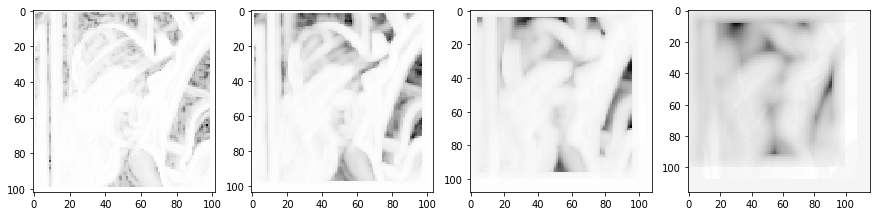

In [27]:
filter_sizes = [3, 5, 9, 17]
plt.figure(figsize=(15, 15))
im_lenna = scipy.misc.imresize(data.lena(), (100, 100))
for index, filter_size in enumerate(filter_sizes):
    plt.subplot(1, len(filter_sizes), index + 1)
    norm_f = norm_filter(filter_size, sigma=15)
    divisive(im_lenna.copy(), filter_size, norm_f)

### 驚きの白さ！  orz


びびったけど、これが多分、コントラストが小さい局所領域ほどコントラストが増幅されて大変なことになるやつ  
※あとなんか知らんけどすごく処理が重い

In [ ]:
# 定数cを追加（文字が小さくて気づかなかったけど、書籍に「1.0とした場合」って書いてあったので1.0をデフォにしています
def divisive(im_lenna, filter_size, norm_f, c=1.0):
    gray_im_lenna = cv2.cvtColor(im_lenna, cv2.COLOR_RGB2GRAY)
    image_size = gray_im_lenna.shape[0]
    gray_im_lenna = gray_im_lenna.astype(np.float32)
    # Rescaling. これないと処理がすごく遅い
    gray_im_lenna = (gray_im_lenna - np.min(gray_im_lenna)) / float(np.max(gray_im_lenna) - np.min(gray_im_lenna))
    padded_lenna, pad_size = add_padding_center(gray_im_lenna, filter_size)

    nditer = np.nditer(np.mgrid[0:image_size, 0:image_size][0], flags=['multi_index'])
    while not nditer.finished:
            # norm_f[p, q] -> 重み
            # padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] -> x_{i + p, j + q}
            subtractive_v = np.sum([padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] * norm_f[p, q] \
                                                                                           for p in range(filter_size) for q in range(filter_size)])
            sigma = np.sum([(padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] - subtractive_v) ** 2 * norm_f[p, q] \
                                                                                           for p in range(filter_size) for q in range(filter_size)])
            # ※1
            # さっきの除算正規化の式に閾値を用意してあげる
            padded_lenna[nditer.multi_index] = padded_lenna[nditer.multi_index] - subtractive_v / np.maximum(c, np.sqrt(sigma))
            nditer.iternext()

    plt.imshow(padded_lenna, cmap='gray')

※1

$$
\begin{align}
z_{ij}= \frac{x_{ij} - \bar{x_{ij}}}{max(c, \sigma_{ij})}
\end{align}
$$

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


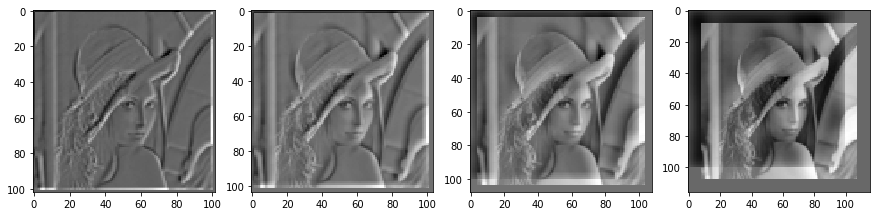

In [177]:
filter_sizes = [3, 5, 9, 17]
plt.figure(figsize=(15, 15))
im_lenna = scipy.misc.imresize(data.lena(), (100, 100))
for index, filter_size in enumerate(filter_sizes):
    plt.subplot(1, len(filter_sizes), index + 1)
    norm_f = norm_filter(filter_size, sigma=15)
    divisive(im_lenna, filter_size, norm_f)

In [178]:
# もひとつの式も試す
def divisive(im_lenna, filter_size, norm_f, c=1.0):
    gray_im_lenna = cv2.cvtColor(im_lenna, cv2.COLOR_RGB2GRAY)
    image_size = gray_im_lenna.shape[0]
    gray_im_lenna = gray_im_lenna.astype(np.float32)
    # Rescaling
    gray_im_lenna = (gray_im_lenna - np.min(gray_im_lenna)) / float(np.max(gray_im_lenna) - np.min(gray_im_lenna))
    # Standardization
    # gray_im_lenna = 
    padded_lenna, pad_size = add_padding_center(gray_im_lenna, filter_size)

    nditer = np.nditer(np.mgrid[0:image_size, 0:image_size][0], flags=['multi_index'])
    while not nditer.finished:
            # norm_f[p, q] -> 重み
            # padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] -> x_{i + p, j + q}
            subtractive_v = np.sum([padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] * norm_f[p, q] \
                                                                                           for p in range(filter_size) for q in range(filter_size)])
            sigma = np.sum([(padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q] - subtractive_v) ** 2 * norm_f[p, q] \
                                                                                           for p in range(filter_size) for q in range(filter_size)])
            # ※1
            # さっきの除算正規化の式に閾値を用意してあげる
            padded_lenna[nditer.multi_index] = padded_lenna[nditer.multi_index] - subtractive_v / np.sqrt(c + sigma)
            nditer.iternext()

    plt.imshow(padded_lenna, cmap='gray')

※1

$$
\begin{align}
z_{ij}= \frac{x_{ij} - \bar{x_{ij}}}{\sqrt{c + \sigma_{ij}^2}}
\end{align}
$$

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


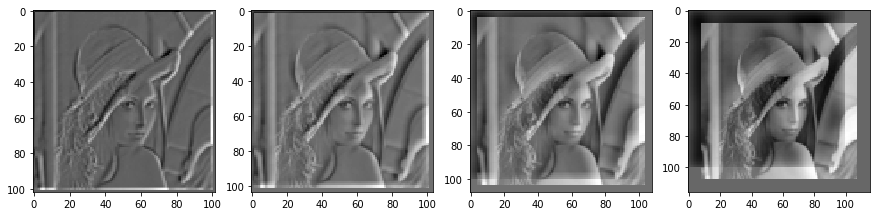

In [179]:
filter_sizes = [3, 5, 9, 17]
plt.figure(figsize=(15, 15))
im_lenna = scipy.misc.imresize(data.lena(), (100, 100))A
for index, filter_size in enumerate(filter_sizes):
    plt.subplot(1, len(filter_sizes), index + 1)
    norm_f = norm_filter(filter_size, sigma=15)
    divisive(im_lenna, filter_size, norm_f)

### 多チャネル画像の正規化

ここまでわかっているのならあと1次元増えてもいけるはず!!!（小声）


・・・と、思いましたが、$w_{pqk}$って、合計すると1になるのかな？
これがわかりません。

とりあえず、1にならない方法で進めてみました。

In [211]:
def add_padding_center_channel(data, filter_size):
    if type(data) != np.ndarray:
        raise Exception('data must be numpy.ndarray')  
        
    image_shape = data.shape
    if (filter_size %2) != 0:
        # odd
        pad_size = (filter_size -1) // 2
    else:
        #even
        pad_size = filter_size // 2
    # 画像の次元が増えたため、paddingパラメータを修正
    return np.pad(data, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant',  constant_values=0), pad_size

In [212]:
def subtractive_channel(im_lenna, filter_size, norm_f, channel=3):
    image_size = im_lenna.shape[0]
    im_lenna = im_lenna.astype(np.float32)
    # Rescaling
    im_lenna = (im_lenna - np.min(im_lenna)) / float(np.max(im_lenna) - np.min(im_lenna))
    # Standardization
    # gray_im_lenna = 
    padded_lenna, pad_size = add_padding_center_channel(im_lenna, filter_size)

    nditer = np.nditer(np.mgrid[0:image_size, 0:image_size, 0:channel][0], flags=['multi_index'])
    while not nditer.finished:
            subtractive_v = np.sum([padded_lenna[nditer.multi_index[0] + p, nditer.multi_index[1] + q, k] * norm_f[p, q] \
                                                                                           for k in range(channel) for p in range(filter_size) for q in range(filter_size)])
            padded_lenna[nditer.multi_index] -= subtractive_v
            nditer.iternext()

    plt.imshow(padded_lenna, cmap='gray')

/Users/kazumatamaki/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


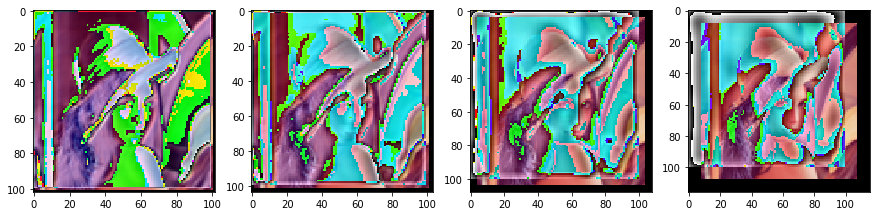

In [213]:
filter_sizes = [3, 5, 9, 17]
plt.figure(figsize=(15, 15))
im_lenna = scipy.misc.imresize(data.lena(), (100, 100))
for index, filter_size in enumerate(filter_sizes):
    plt.subplot(1, len(filter_sizes), index + 1)
    norm_f = norm_filter(filter_size, sigma=15)
    subtractive_channel(im_lenna, filter_size, norm_f)

・・・・・・・・？

出来ていない気がする

続き

# 勾配の計算



* 畳み込み層計算のおさらい
    * $u_{ijm} = \sum_{k=0}^{K-1}\sum_{p=0}^{H-1}\sum_{q=0}^{H-1} z_{i+p,j+q,k}^{(l-1)}h_{pqkm}+b_{ijm}$  (6.2)
    * $z_{ijm} = f(u_{ijm})$  (6.3)
* 畳み込みの計算は前半複雑だけど、中身は線形計算なので、重み行列$W$を適当に定義してあげれば、２章で扱った順伝播型ネットワーク、全結合層と同様に表せることができる

$$
\begin{align}
u^{(l)}= W^{(l)} z^{(l-1)} + b^{(l)} \\
z^{(l)}= f^{(l)} (u^{(l)})
\end{align}
$$

* 上の式はP50にある4.14aと4.14bの式と同じ
* 畳み込み式のおさらい
    * $z^{(l-1)}$は畳みこむ前の画像
    * $u^{(l)}$は畳み込んだあとの画像
    * $z^{(l)}$は畳み込んだあと、活性化関数からoutputされた画像（mapと呼ばれていました）
* $W$はサイズ$H \times H \times K$のM個のフィルタの係数$h_{pqkm}$を、式（6.2）の畳み込みを再現するように規則的に並べたものです。
* 多くの成分が0となる疎行列になる

要はですよ


これから

<img src="./img/10.png" style="height:300px;">
こゆのつくりたい
<img src="./img/20.png" style="height:300px;">

<img src="./img/21.png" style="height:300px;">

* 基本的には全結合層と同じだけど、同じフィルタの係数が何度も$W^{(l)}$に現れる（重み共有）ことを考慮する必要があります
* これはフィルタの係数$h_{pqkm}$から行列$W = W^{(l)}$を作る過程を次のように表す
    * フィルタの係数$h_{pqkm}$を適当な順で並べて成分数$H \times H \times K \times M$のベクトル$h$を作る
    * 次に$h$と同じ長さを持ち、$h$と内積をとると$l-1$層のユニット$i$（$z^{(l-1)}$）と$l$層のユニットで$j$（$u^{(l)}$）間の重み$w_{ij}$を与えるベクトル$t_{ji}$を定義する
    * ？？？？？？!!!？？？!!？？？？？？？？？？？？？!!!!!？？？？？？？？？？？？？？!？？？？
    * あひゃ, (｡A ｡ ) あひゃ, (ﾟ∀ﾟ ).ひゃひゃ
    * 何いっているかさっぱりわからねー！！！
    

$$
\begin{align}
w_{ji} = t_{ji}^{T}h
\end{align}
$$

<img src="./img/6a145ae0.jpg">

### 落ち着きを取り戻しちゃんと整理
* $z^{(l-1)}$は前のレイヤーからもらった画像
* $u^{(l)}$は今のレイヤーから畳み込まれた画像
* その２つを使ったベクトル
* $w_{ji} = h_{0100}$というのがありえる
* ....

* $t_{ji}$は高々１つの成分が1をとり、それ以外は0となるベクトル
    * => $t_{ji}$は多くとも1つの成分が1をとり、それ以外は0となるベクトル
* $t_{ij}$の成分を$t_{ijr}$と書き、全結合層に対する勾配計算の式を形式的に適用すると、この層の重み$W = W^{(l)}$の勾配は下記で与えられる
    * 成分って何？
        * [http://www24.atpages.jp/venvenkazuya/mathC/matrix2.php](http://www24.atpages.jp/venvenkazuya/mathC/matrix2.php)
        * >行列の中に含まれている各項を成分と呼びます
    * 例えば、$i = 3, j = 2$とき、成分は2としたら、$r = 2$となる？
    * てか、$t_{ij}$の$j$と$r$って一緒になんね？
$$
\begin{align}
\partial W =  \delta^{(l)} z^{(l-1)^{T}}
\end{align}
$$


上の式のイメージ

<img src="./img/42737f02-7f8c-869a-5e7b-b2511e93dd67.png">

* [引用元](http://qiita.com/eijian/items/c947fb6b5e7a49858fb4)

* $W$の多くの成分はもともと0であり、そうでもない成分も重み共有により、同じ変数（フィルタの係数）に対応します.
* そこでフィルタの係数$h$については勾配$\partial h$に変形する必要がある
* 微分の線形性から、$\partial h$の成分$r$は次のように表せます.

$$
\begin{align}
(\partial h)_{r} = \sum_{i,j}(T_{r} \odot \partial W)_{ji}
\end{align}
$$

これ、式(6.5）

* $\odot$は行列の成分ごとの積を表し、和は行列の全成分の和を表します
    * $\odot$ <- なにこれ？
    * アダマール積（カトリ・ラオ積、シューア積とかも記述があるが、沖縄にいる数学者からコメントもらったら「アダマール積派です」と回答もらったのでそれにする
$$
\begin{align}
\begin{bmatrix}
1 \\
2
\end{bmatrix} \odot
\begin{bmatrix}
3 \\
4
\end{bmatrix} = 
\begin{bmatrix}
1 * 3\\
2 * 4
\end{bmatrix} = 
\begin{bmatrix}
3 \\
8
\end{bmatrix}
\end{align}
$$
* なお、層$l$のデルタは層$l + 1$のデルタ$\delta^{(l+1)}$および、層$l+1$について同様に定義された重み行列$W^{(l+1)}$を用いて次のように計算される

$$
\begin{align}
\delta^{(l)} = f^{(l)'} (u^{l}) \odot (W^{(l+1)T}\delta^{(l+1)})
\end{align}
$$

* 何やってんのか、わけわかめで泣きそうになる(´・ω・｀)
* パズルみたいに分解してやりますよっと

### やりたいこと

* 勾配である$\frac{\partial{E}}{\partial{W^{(l)}}} = \partial{W}$を求めたい
* $\partial{W} = \delta^{(l)}z^{(l-1)^T}$

### 書いてあることからわかること

* $\delta^{(l)}$の求め方は(6.5)から$f^{(l)'} (u^{l}) \odot (W^{(l+1)T}\delta^{(l+1)})$を解けばわかる


### ググった資料からわかること

* この式は誤差逆伝播で使われている式に当てはめると$\delta^{(l)} = f^{(l)'} u_{j}^{(l)} (\sum_{k}w_{kj}^{(l+1)}\delta_{k}^{(l+1)})$とかける
* [https://www.slideshare.net/matsukenbook/ss-50545587](https://www.slideshare.net/matsukenbook/ss-50545587)

* プーリング層には学習の対象となるパラメータはない。なので、勾配を計算する必要はない
* けど、下の層があれば、そこに伝える逆伝播の計算は必要となる
* プーリングの種類ごとに$W^{(l+1)}$を定め、式（6.5）を計算します
* 平均プーリング層では、層$l+1$のユニット$j$のサイズ$H \times H$のプーリング領域を$P_{j}$として

$$
\begin{align}
f(x) = \left\{
\begin{array}{ll}
\frac{1}{H^{2}}\,\,if\,\,i \in{P_{j}} \\
0\,\,otherwise
\end{array}
\right.
\end{align}
$$

* とする
* 出力層のユニットデルタに$W^{(l+1)T}$をかけることで、それらが入力層に均等に割り振られることになる

# ちなみに

ゼロからディープに書いてあるソースをコピペするとこんな感じ

In [ ]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):  # dout -> δ
        # 短くね・・・・・
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        # δ bias
        self.db = np.sum(dout, axis=0)
        # δ weight
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx